# import modules

In [27]:
!pip install lxml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 2.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for lxml: filename=lxml-4.9.0-cp39-cp39-macosx_11_0_arm64.whl size=1441896 sha256=dc57f6a4449da8d5c3bdc22b16dd8f636cd0e8a8f6dbcf3c4134c0b07fb24604
  Stored in directory: /private/tmp/pip-ephem-wheel-cache-_2jv93gv/wheels/51/e7/8f/449fb7c30cec16495fa25330c905328f89d27c4e3c0306c418
Successfully built lxml


In [62]:
import os
from glob import glob

import numpy as np
import pandas as pd

import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm

# load, parse and show data

In [29]:
data = pd.DataFrame()
data['image_path'] = glob('data/images/*')
data['xml_path'] = data['image_path'].apply(lambda x: 'data/xml/' + x.split('/')[-1].split('.')[0] + '.xml')

In [44]:
from bs4 import BeautifulSoup

def parse_xml(file):

    with open(file, 'rb') as f:
        xml_data = f.read()
    Bs_data = BeautifulSoup(xml_data, "html.parser").find_all('object')
    
    labels = [x.find('name').contents[0] for x in Bs_data]
    
    annotations = []
    for bd in Bs_data:
        annotations.append([int(x.contents[0]) for x in bd.find_all('bndbox')[1:]])
        
    return {'labels':labels, 'annots':annotations}

In [45]:
files = glob('data/images/*')
# files.sort(reverse=False)

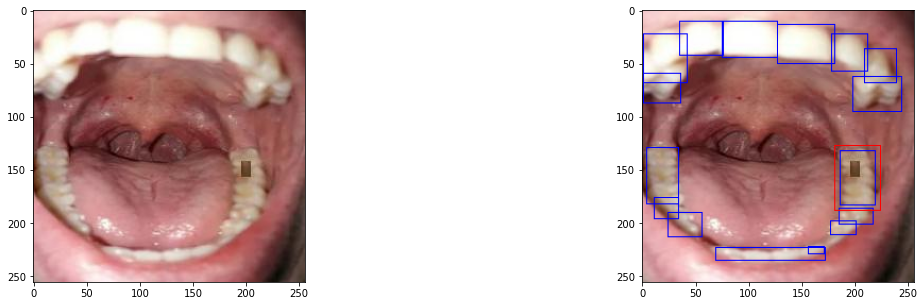

In [364]:
for file in [files[10]]:

# for file in ['data/images/399.jpg']:

    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB).copy()
    xml = parse_xml('data/xml/'+file.split('/')[-1].split('.')[0]+'.xml')
    
    image_bbox = image.copy()
    
    for n, annot in zip(xml['labels'], xml['annots']):
        x_min = annot[0]
        x_max = annot[2]
        y_min = annot[1]
        y_max = annot[3]
        if n == 'caries':
            image_bbox = cv2.rectangle(image_bbox, (x_min, y_min), (x_max, y_max), (255, 0, 0), 1)
        else:
            image_bbox = cv2.rectangle(image_bbox, (x_min, y_min), (x_max, y_max), (0, 0, 255), 1)
    
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].imshow(image)
    ax[1].imshow(image_bbox)
    plt.show()

In [365]:
file

'data/images/1179.jpg'

In [366]:
bboxes = xml['annots'][:]

In [367]:
# xml

In [368]:
# x_min, y_min, x_max, y_max

In [369]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
X = [[x] for x in np.array(bboxes)[:, 1]]
KMeans(n_clusters=2).fit_predict(X)
# AffinityPropagation().fit_predict([[x] for x in np.array(bboxes)[:, 1]])

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [370]:
max_dist = 0
for i in np.array(bboxes)[:, 1]:
    for j in np.array(bboxes)[:, 1]:
        if max(i, j) - min(i, j) > max_dist:
            max_dist = max(i, j) - min(i, j)

In [375]:
up_down_clusters = KMeans(n_clusters=2).fit_predict(X)

In [376]:
up_down_clusters

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

175.88888888888889

In [381]:
np.mean([np.array(bboxes)[:, 1][i] for i in range(len(np.array(bboxes)[:, 1])) if up_down_clusters[i] == 1])
np.mean([np.array(bboxes)[:, 1][i] for i in range(len(np.array(bboxes)[:, 1])) if up_down_clusters[i] == 0])

29.25

In [371]:
X

[[13],
 [10],
 [10],
 [22],
 [59],
 [62],
 [36],
 [22],
 [132],
 [129],
 [186],
 [198],
 [223],
 [222],
 [190],
 [176],
 [127]]

In [372]:
silhouette_score(X, KMeans(n_clusters=2).fit_predict(X))

0.7395888160197552

In [373]:
max_dist

213

In [374]:
if max_dist > 80:
    print('Up and Down')

Up and Down


In [276]:
# silhouette_score(X, KMeans(n_clusters=1).fit_predict(X))

In [228]:
np.array(bboxes)[:, 1]

array([180, 197, 215, 236])

# make dataset

In [69]:
data = pd.DataFrame()

for file in tqdm(files):

    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB).copy()
    xml = parse_xml('data/xml/'+file.split('/')[-1].split('.')[0]+'.xml')
    
    temp = pd.DataFrame(index=[i for i in range(len(xml['labels']))])
    
    temp['path'] = file
    temp['height'] = image.shape[0]
    temp['width'] = image.shape[1]
    
    if len(xml['labels']) == 0:
        pass
    else:
        temp['label'] = xml['labels']
        temp[['x_min', 'y_min', 'x_max', 'y_max']] = xml['annots']
        data = pd.concat([data, temp], ignore_index=True)

100%|████████████████████████████████████████| 901/901 [00:03<00:00, 278.16it/s]


In [71]:
data

,path,height,width,label,x_min,y_min,x_max,y_max
0,data/images/823.jpg,256,256,teeth,201,145,249,198
1,data/images/823.jpg,256,256,teeth,217,198,256,255
2,data/images/189.jpg,256,256,teeth,134,86,153,98
3,data/images/189.jpg,256,256,teeth,110,86,132,98
4,data/images/189.jpg,256,256,teeth,100,89,110,98
...,...,...,...,...,...,...,...,...
6189,data/images/190.jpg,256,256,teeth,160,56,180,69
6190,data/images/190.jpg,256,256,teeth,179,61,196,75
6191,data/images/190.jpg,256,256,teeth,178,134,190,146
6192,data/images/190.jpg,256,256,caries,171,116,201,140


In [124]:
for path in data[data.label == 'caries'].path.unique():

    caries_data = data[(data.path == path)&(data.label == 'caries')]
    teeth_data = data[(data.path == path)&(data.label == 'teeth')]
    
    poses = []

    for i, caries_val in caries_data.iterrows():
        
        pos_bool = False
        min_teeth_square = 10000000000
        caries_square = (caries_val.x_max - caries_val.x_min)*(caries_val.y_max - caries_val.y_min)
        
        for j, teeth_val in teeth_data.iterrows():
            
            if caries_val.x_min <= teeth_val.x_min and caries_val.x_max >= teeth_val.x_max \
                and caries_val.y_min <= teeth_val.y_min and caries_val.y_max >= teeth_val.y_max:
                poses.append('out')
                pos_bool = True
                break
            
            elif caries_val.x_min >= teeth_val.x_min and caries_val.x_max <= teeth_val.x_max \
                and caries_val.y_min >= teeth_val.y_min and caries_val.y_max <= teeth_val.y_max:
                poses.append('in')
                pos_bool = True
                break
                
            if (teeth_val.x_max - teeth_val.x_min)*(teeth_val.y_max - teeth_val.y_min) < min_teeth_square:
                min_teeth_square = (teeth_val.x_max - teeth_val.x_min)*(teeth_val.y_max - teeth_val.y_min)
        
        if not pos_bool and caries_square < min_teeth_square:
            poses.append('in')
        elif not pos_bool and caries_square > min_teeth_square:
            poses.append('out')
        elif not pos_bool:
            poses.append('')
            
    data.loc[(data.path == path)&(data.label == 'caries'), 'pose'] = poses

In [128]:
data.to_csv('data.csv', index=False)

# data for segmentation

In [130]:
data[data.pose == 'in']

,path,height,width,label,x_min,y_min,x_max,y_max,pose
109,data/images/1186.jpg,256,256,caries,247,209,256,224,in
154,data/images/1031.jpg,256,256,caries,33,48,41,65,in
155,data/images/1031.jpg,256,256,caries,46,216,59,229,in
156,data/images/1031.jpg,256,256,caries,43,197,54,213,in
157,data/images/1031.jpg,256,256,caries,177,206,185,222,in
...,...,...,...,...,...,...,...,...,...
5862,data/images/595.jpg,256,256,caries,25,50,40,60,in
5941,data/images/0_ (7).jpg,256,256,caries,79,142,89,155,in
6144,data/images/621.jpg,256,256,caries,16,157,43,185,in
6145,data/images/621.jpg,256,256,caries,18,185,48,211,in


In [395]:
image = cv2.imread('data/images/0_ (1).jpg')

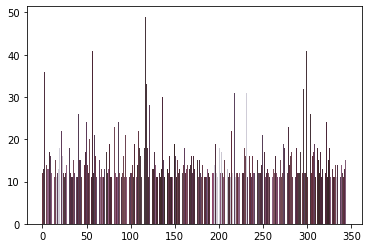

In [392]:
import PIL
from PIL import Image
from matplotlib import pyplot as plt

im = Image.open('data/images/0_ (1).jpg')
w, h = im.size  
colors = im.getcolors(w*h)
colors = [col for col in colors if col[0] > 10]

def hexencode(rgb):
    r=rgb[0]
    g=rgb[1]
    b=rgb[2]
    return '#%02x%02x%02x' % (r,g,b)

for idx, c in enumerate(colors):
    plt.bar(idx, c[0], color=hexencode(c[1]))

plt.show()